In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def build_model(num_timesteps, num_samples, vocab_size, embedding_size,
                keep_prob=1.0, cell_size=256):
    """
    Build an RML-enabled seq2seq model which accepts `num_samples` different
    target output sequences for a given input sequence.
    
    Returns:
        inputs: List of `batch_size` tensors; list of input ID tensors
        targets: List of lists of `batch_size` tensors; each sublist is a
            sequence of target ID tensors
        loss: Sequence loss averaged over the `num_samples`-many target
            sequences
    """
    cell = tf.nn.rnn_cell.GRUCell(cell_size)
    if keep_prob < 1.0:
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
        
    inputs = [tf.placeholder(tf.int32, shape=(None,), name="inputs/%i" % t)
              for t in range(num_timesteps)]
    targets = [[tf.placeholder(tf.int32, shape=(None,), name="targets/%i/%i" % (i, t))
                for t in range(num_timesteps)]
               for i in range(num_samples)]
    real_targets = [tf.placeholder(tf.int32, shape=(None,), name="targets/real/%i" % t)
                    for t in range(num_timesteps)]
    
    # Decoder inputs: prepend GO token to target sequence; remove last value from targets
    decoder_inputs = [tf.pack([tf.zeros_like(targets_i[0])] + targets_i[:num_timesteps - 1])
                      for targets_i in targets]
    real_decoder_inputs = [tf.zeros_like(real_targets[0])] + real_targets[:-1]
    
    weights = [tf.ones_like(targets[0][0], dtype=tf.float32)
               for t in range(num_timesteps)]
    
    def seq2seq_loss(dec_inp_i, targets_i):
        outputs, state = tf.nn.seq2seq.embedding_rnn_seq2seq(
            inputs, targets_i, cell, vocab_size, vocab_size, embedding_size)
        
        loss = tf.nn.seq2seq.sequence_loss(outputs, targets_i, weights)
        return loss
    
    # Build a separate seq2seq graph for each of the `num_samples` feedforwards
    # we perform for each batch.
    seq2seq_loss = tf.make_template("seq2seq_loss", seq2seq_loss)
    losses = [seq2seq_loss(dec_inp_i, targets_i)
              for dec_inp_i, targets_i in zip(decoder_inputs, targets)]
    # Hill-climb with mean gradients = hill-climb with mean loss.
    loss = tf.add_n(losses) / float(len(losses))
    
    real_loss = seq2seq_loss(real_decoder_inputs, real_targets)
    
    return inputs, targets, loss, real_targets, real_loss

In [3]:
def modify_with_hamming_distance(y, distance, vocab_size):
    assert distance >= 0
    assert distance <= len(y)
    if distance == 0:
        return np.copy(y)
    
    idxs = np.random.choice(len(y), replace=False, size=distance)
    replacements = np.random.choice(vocab_size, size=distance)
    # TODO: account for case where replacement is same as existing char
    
    ret = np.copy(y)
    ret[idxs] = replacements
    return ret

def sample_targets_hamming_distance(y, n, vocab_size, p=0.8):
    """
    Sample `n` partially-correct targets by modifying the correct target
    sequence `y` under a Hamming distance reward function.
    """
    distances = np.minimum(len(y), np.random.geometric(p, n) - 1)
    return [modify_with_hamming_distance(y, distance, vocab_size)
            for distance in distances]

In [4]:
def train_batch(model, train_op, sess, batch_size, num_timesteps,
                num_samples, vocab_size):
    inputs, targets, loss, real_targets, real_loss = model
    
    b_inputs = np.random.choice(vocab_size, size=(num_timesteps, batch_size),
                                replace=True)
    b_targets = np.copy(b_inputs)
    b_targets_real = np.copy(b_targets)
    b_targets = [sample_targets_hamming_distance(b_targets_i, num_samples, vocab_size)
                 for b_targets_i in b_targets]
    b_targets = np.array(b_targets).transpose(1, 0, 2)
    
    feed = {inputs[t]: b_inputs_t for t, b_inputs_t in enumerate(b_inputs)}
    feed.update({real_targets[t]: b_targets_real_t
                 for t, b_targets_real_t in enumerate(b_targets_real)})
    feed.update({targets[j][t]: b_targets_samp_t
                 for j, b_targets_samp in enumerate(b_targets)
                 for t, b_targets_samp_t in enumerate(b_targets_samp)})
                 
    loss_b, real_loss_b, _ = sess.run((loss, real_loss, train_op), feed)
    return loss_b, real_loss_b

In [5]:
def train_model(num_samples, lr=0.1):
    NUM_TIMESTEPS = 10
    VOCAB_SIZE = 300
    EMBEDDING_SIZE = 128

    g = tf.Graph()
    with g.as_default():
        model = build_model(NUM_TIMESTEPS, num_samples, VOCAB_SIZE,
                            EMBEDDING_SIZE)
        optimizer = tf.train.MomentumOptimizer(lr, 0.9)
        train_op = optimizer.minimize(model[2])

    sess = tf.InteractiveSession(graph=g)
    sess.run(tf.initialize_all_variables())
    
    losses, real_losses = [], []
    for i in range(500):
        loss, real_loss = train_batch(model, train_op, sess, 64, NUM_TIMESTEPS,
                                      num_samples, VOCAB_SIZE)
        losses.append(loss)
        real_losses.append(real_loss)
        if i % 100 == 0:
            print("\t", i)
                
    return losses, real_losses

In [6]:
losses = {}

for lr in [0.5, 0.1, 0.05]:
    for num_samples in [1, 2, 4, 8]:
        print(lr, num_samples)
        losses[(lr, num_samples)] = train_model(num_samples, lr=lr)

0.5 1
	 0
	 100
	 200
	 300
	 400
0.5 2
	 0
	 100
	 200
	 300
	 400
0.5 4
	 0
	 100
	 200
	 300
	 400
0.5 8
	 0
	 100
	 200
	 300
	 400
0.1 1
	 0
	 100
	 200
	 300
	 400
0.1 2
	 0
	 100
	 200
	 300
	 400
0.1 4
	 0
	 100
	 200
	 300
	 400
0.1 8
	 0
	 100
	 200
	 300
	 400
0.05 1
	 0
	 100
	 200
	 300
	 400
0.05 2
	 0
	 100
	 200
	 300
	 400
0.05 4
	 0
	 100
	 200
	 300
	 400
0.05 8
	 0
	 100
	 200
	 300
	 400


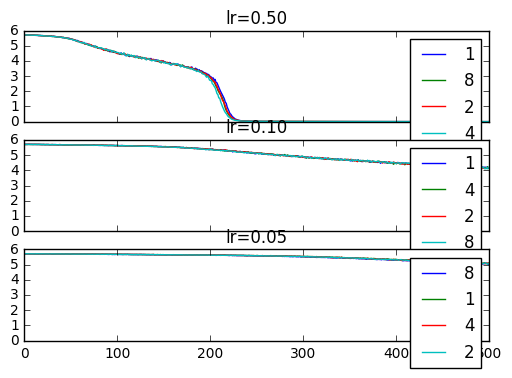

In [13]:
learning_rates = set(lr for lr, _ in losses.keys())
fig, axes = plt.subplots(len(learning_rates), 1, sharex=True, sharey=True)

for learning_rate, axis in zip(learning_rates, axes):
    lines = []
    axis.set_title("lr=%.02f"%learning_rate)
    for (lr_j, num_samples), (_, real_losses_j) in losses.items():
        if lr_j != learning_rate: continue
        line, = axis.plot(real_losses_j, label=str(num_samples))
        lines.append(line)
    axis.legend(handles=lines)

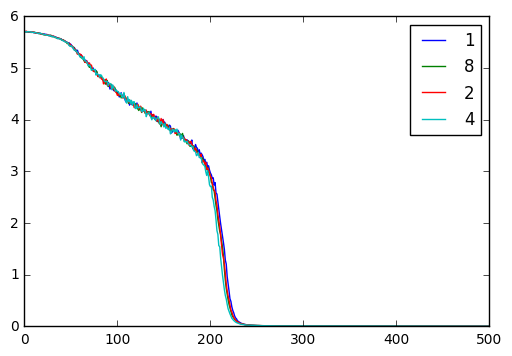

In [14]:
plots = []
for (lr, num_samples), (_, real_losses_j) in losses.items():
    if lr != 0.5: continue
    plot, = plt.plot(real_losses_j, label=str(num_samples))
    plots.append(plot)
plt.legend(handles=plots)